In [78]:
from sklearn import linear_model
from scipy.stats import t,laplace,norm,multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression, Ridge
 
%matplotlib inline

### Linear Gaussian Systems

In [2]:
def pltcontour(mu,sigma):
    x1,x2 = np.mgrid[-10:10:.05, -10:10:.05]
    pos = np.dstack((x1, x2))
    rv = multivariate_normal(mu,sigma)
    plt.contour(x1, x2, rv.pdf(pos))
    plt.xlim([-10,10])
    plt.ylim([-10,10])

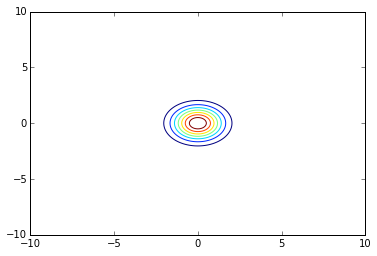

In [4]:
# assume a Gaussian prior on the true location of the airplane
mu0 = [0,0]
sigma0 = [[1, 0], [0, 1]]
pltcontour(mu0,sigma0)

[ 0.35        0.66666667]
[[ 0.75        0.        ]
 [ 0.          0.44444444]]
[ 0.5         0.82142857]
[[ 0.6         0.        ]
 [ 0.          0.28571429]]
[ 0.61666667  0.92105263]
[[ 0.5         0.        ]
 [ 0.          0.21052632]]
[ 0.67142857  0.91666667]
[[ 0.42857143  0.        ]
 [ 0.          0.16666667]]


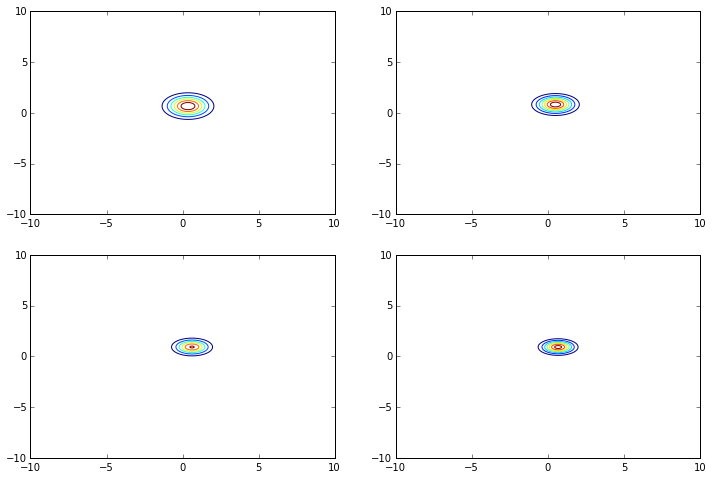

In [5]:
muy = mu0
sigmay = sigma0
# noisy observations
#xs = [[1,1],[1.2,0.8],[1.1,1.2],[1.2,1.3],[1,1],[1,1],[1,1],[1,1]]
xs = [[1.4,1.2],[1.1,1.1],[1.2,1.2],[1.0,0.9]]
# sensor error covariance
sigmax = [[3,0],[0,0.8]]
# compute posterior for y
i = 1
fig = plt.figure(figsize=[12,8])
for x in xs:
    x = np.array(x)
    sigmay_post = np.linalg.inv(np.linalg.inv(sigmay) + np.linalg.inv(sigmax))
    muy_post = np.dot(sigmay_post,np.dot(np.linalg.inv(sigmax),x) + np.dot(np.linalg.inv(sigmay),muy))
    muy = muy_post
    sigmay = sigmay_post
    print muy
    print sigmay
    plt.subplot(len(xs)/2,2,i)
    i = i + 1
    pltcontour(muy,sigmay)

In [32]:
# We can also do this in a one shot approach by using all of the observations at once -- with the same result as before
sigmay_post = np.linalg.inv(np.linalg.inv(sigma0) + len(xs)*np.linalg.inv(sigmax))
muy_post = np.dot(sigmay_post,len(xs)*np.dot(np.linalg.inv(sigmax),np.mean(np.array(xs),axis=0))+np.dot(np.linalg.inv(sigma0),mu0))
print muy_post
print sigmay_post

[ 0.67142857  0.91666667]
[[ 0.42857143  0.        ]
 [ 0.          0.16666667]]


### Ordinary Linear Regression
We use np.polyfit with order = 1 to fit a line to the 1-D data.

In [85]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

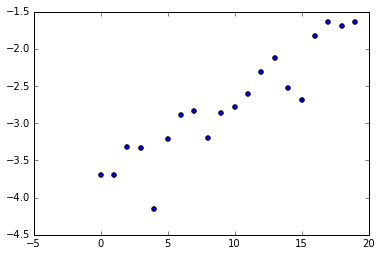

In [41]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,sqrt(sigma2),x.shape[0])
plt.scatter(x,y)


In [46]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print pretty_print_linear(lr.coef_,lr.intercept_)

-3.821 + 0.113 * X1


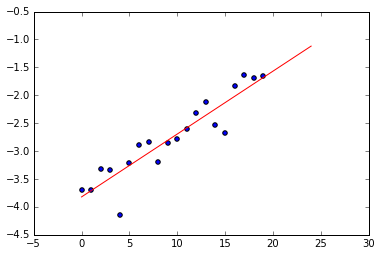

In [47]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest,ytest, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

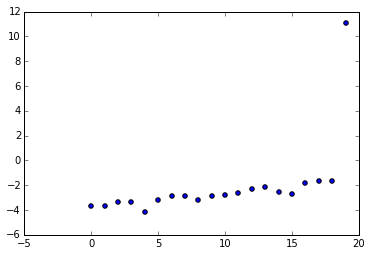

In [49]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [50]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print pretty_print_linear(lr.coef_,lr.intercept_)


-4.913 + 0.295 * X1


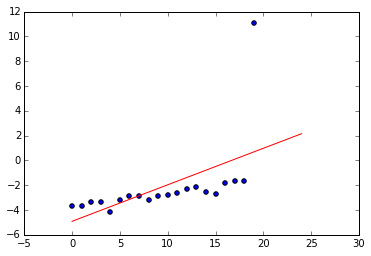

In [51]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Using robust regression
The statsmodels package has a robust linear regression model function (rlm) which uses a different norm than (squared) for the loss function. 

In [62]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([np.ones(x.shape[0]),x.flatten()]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print pretty_print_linear(w[1:],w[0])


-3.786 + 0.117 * X1


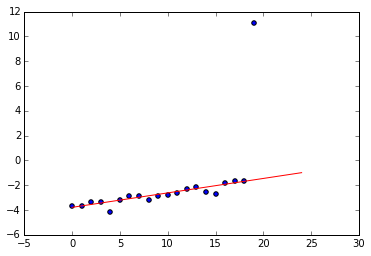

In [63]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = w[0] + w[1]*xtest
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Handling outliers using other distributions
Below are some alternate distributions with less fat tail than Gaussian.

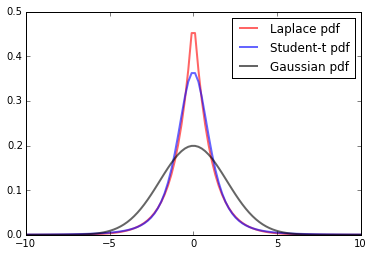

In [12]:
# comparing student-t, norm, laplace
s = np.linspace(-10,10, 100)
df = 2.74335149908
plt.plot(s, laplace.pdf(s),'r-', lw=2, alpha=0.6, label='Laplace pdf')
plt.plot(s, t.pdf(s,df),'b-', lw=2, alpha=0.6, label='Student-t pdf')
plt.plot(s, norm.pdf(s,0,2),'k-', lw=2, alpha=0.6, label='Gaussian pdf')
plt.legend()

### Impact of correlated variables

In [66]:
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
print pretty_print_linear(lr.coef_,lr.intercept_)

0.033 + 0.984 * X1 + 1.995 * X2 + -0.041 * X3


In [86]:
# adding correlated variables
for i in range(10):
    print "Random seed %s" % i
    np.random.seed(seed=i)
    X_seed = np.random.normal(0, 1, size)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print "Linear model:", pretty_print_linear(lr.coef_,lr.intercept_)
 

Random seed 0
Linear model: -0.021 +  0.728 * X1 +  2.309 * X2 + -0.082 * X3
Random seed 1
Linear model:  0.062 +  1.152 * X1 +  2.366 * X2 + -0.599 * X3
Random seed 2
Linear model: -0.179 +  0.697 * X1 +  0.322 * X2 +  2.086 * X3
Random seed 3
Linear model:  0.065 +  0.287 * X1 +  1.254 * X2 +  1.491 * X3
Random seed 4
Linear model:  0.035 +  0.187 * X1 +  0.772 * X2 +  2.189 * X3
Random seed 5
Linear model: -0.058 + -1.291 * X1 +  1.591 * X2 +  2.747 * X3
Random seed 6
Linear model: -0.077 +  1.199 * X1 + -0.031 * X2 +  1.915 * X3
Random seed 7
Linear model: -0.138 +  1.474 * X1 +  1.762 * X2 + -0.151 * X3
Random seed 8
Linear model:  0.032 +  0.084 * X1 +  1.880 * X2 +  1.107 * X3
Random seed 9
Linear model:  0.048 +  0.714 * X1 +  0.776 * X2 +  1.364 * X3


In [ ]:
# handling correlated 